# Fine scale horizontal gradient of surface buoyancy


__author__ : Aurélie Albert & Julien Le Sommer (MEOM)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : June, 7 2018

__purpose__ : Metric for the intensity of the fine scale dynamics signature on active tracers fields in terms of horizontal buoyancy gradient

__detailed description__ : 
Fine scale horizontal gradient of buoyancy is defined as the horizontal gradient of buoyancy computed from filtered surface fields of temperature and salinity :

$$ M = \nabla_{h} b^{'} $$

where $b^{'}$ is the fine scale part of the buoyancy computed from daily outputs of temperature and salinity.

__practical steps__ :

  * Input data are NATL60-CJM165 daily outputs of surface temperature and salinity
  * step 1.  : Daily buoyancy is computed from input data with cdftool cdfbuoy available here : https://github.com/meom-group/CDFTOOLS
  * step 2. : Filtering of the daily buoyancy data is performed with Lanczos2DHighPassFilter.py.
  * step 3.  : Daily horizontal gradient of fine scale buoyancy is computed with cdftool cdfhgrad also available via : https://github.com/meom-group/CDFTOOLS
  * step 4. : Daily horizontal gradient of fine scale buoyancy is averaged in 1°x1°x1 month boxes
  * step 5. : Maps of horizontal gradient of fine scale buoyancy for every month between October 2012 and September 2013
  
__external libraries needed to run this script__ : 

 * GriddedData : https://github.com/lesommer/codes/blob/master/GriddedData.py
 * oocgcm filtering module : https://github.com/lesommer/oocgcm
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## 0. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4, matplotlib


Software versions
Python 2.7.15 64bit [GCC 7.2.0]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.2
xarray 0.10.4
netCDF4 1.4.0
matplotlib 2.2.2
Thu Jun 07 16:50:05 2018 CEST

In [8]:
## path for modules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf

## histograms
import seaborn as sns
sns.set(color_codes=True)

from decimal import Decimal
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import colorcet as cc

%matplotlib inline

## 3. : Daily horizontal gradient of fine scale buoyancy is averaged in 1°x1°x1 month boxes

In [3]:
#The grid files including a special mask to apply on fine scale data

dirin="/media/extra/DATA/NATL60/NATL60-I/"
gridfile=dirin+"NATL60_v4.1_cdf_mesh_hgr.nc"
grid=xr.open_dataset(gridfile)
navlat= np.squeeze(grid['nav_lat'])
navlon= np.squeeze(grid['nav_lon'])
tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
mask_filt=np.squeeze(xr.open_dataset(dirin+tmask)['tmask'])


In [14]:
#a function to produce a map with boxcar median on a 1°x1° grid
def plot_boxcar(fig,var,loncrs,latcrs,lon,lat,hpvarm,month):
    ''' map of the averaged fine scale variance
    '''
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    truc=np.array(hpvarm)
    truc[truc==0.]=np.nan
    cont=np.isnan(truc)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),vmin=0,vmax=1,cmap=cc.cm.rainbow,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.text(0,30,month,size=25)
    cbar.set_label('Small scale horizontal buoyancy gradient in $10^-7 s^-2$',fontsize=25)
    return fig


In [15]:
# a function that ultimately produce the map from any given month

def plot_hgradb_coarse(t):
    m=str(t+1).zfill(2)
    if t <9:
        year='2013'
    else:
        year='2012'
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }

    tfiles='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb/NATL60-CJM165_y'+year+'m'+m+'d*.1d_hgradbuoy_filt-n80-f0.0125.nc'
    hgradb = xr.open_mfdataset(tfiles,concat_dim='time_counter',decode_times=False)['vohgradb']
    diri='/media/extra/DATA/NATL60/NATL60-I/'
    tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
    mask_filt=np.squeeze(xr.open_dataset(diri+tmask)['tmask'])
    hgradb_mask=np.zeros(hgradb.shape)
    for tt in np.arange(hgradb_mask.shape[0]):
        truc=np.squeeze(hgradb[0,:,:].values)        
        truc[np.where(mask_filt!=1)]=np.nan
        hgradb_mask[tt,:,:]=truc[:,:]   
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hgradb_coarse=np.zeros((hgradb_mask.shape[0],3600,57,90))
    for tt in np.arange(hgradb_coarse.shape[0]):
        truc=np.squeeze(hgradb_mask[0,:,:])        
        hgradbc = crs.return_ravel(np.asarray(truc))
        hgradb_coarse[tt,:,:,:]=hgradbc 
    hgradb_coarse_stack=np.concatenate(hgradb_coarse,axis=0)
    hgradb_coarse_median=np.nanmedian(hgradb_coarse_stack,axis=0)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)

    fig = plt.figure(figsize=(20, 15))
    truc=plot_boxcar(fig,1e7*hgradb_coarse_median,loncrsm, latcrsm,navlon,navlat,hgradb[0],month[t+1])
    plt.savefig("NATL60_hgrad_small_scale_median_m"+m+".png")


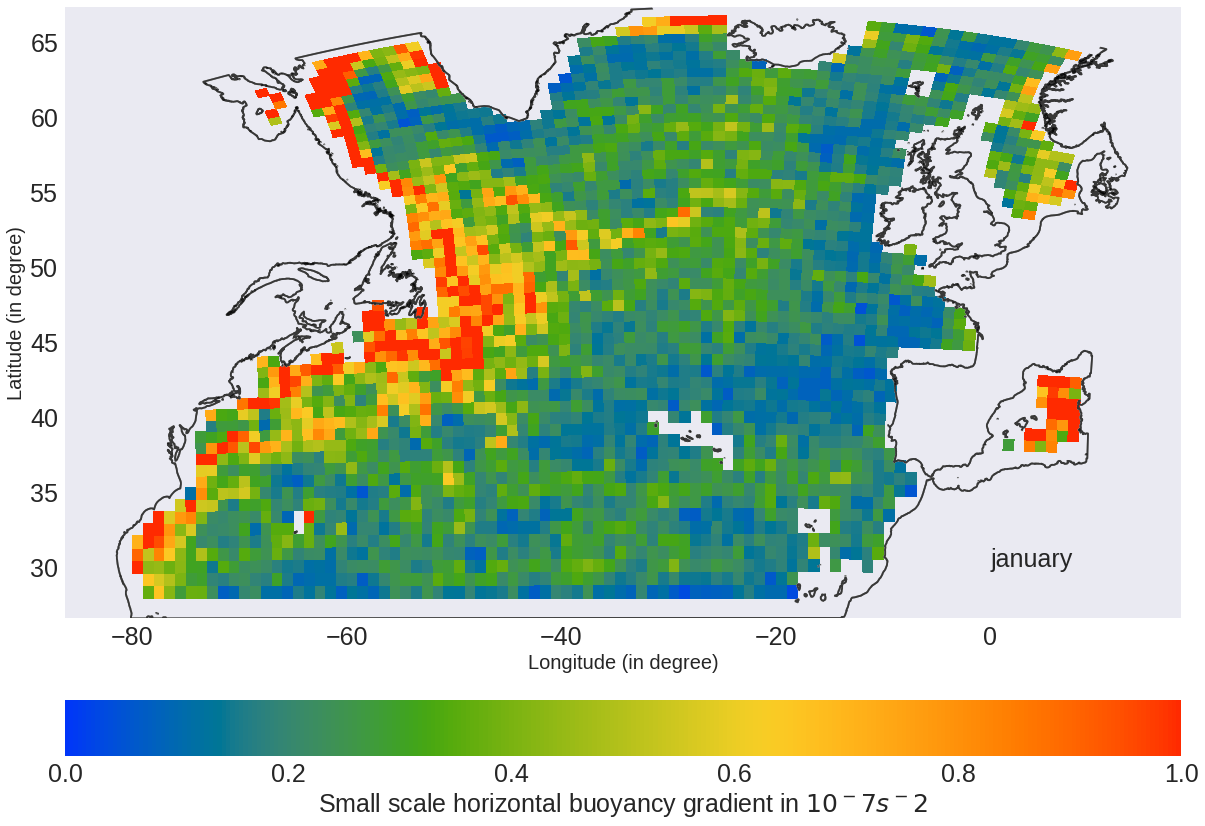

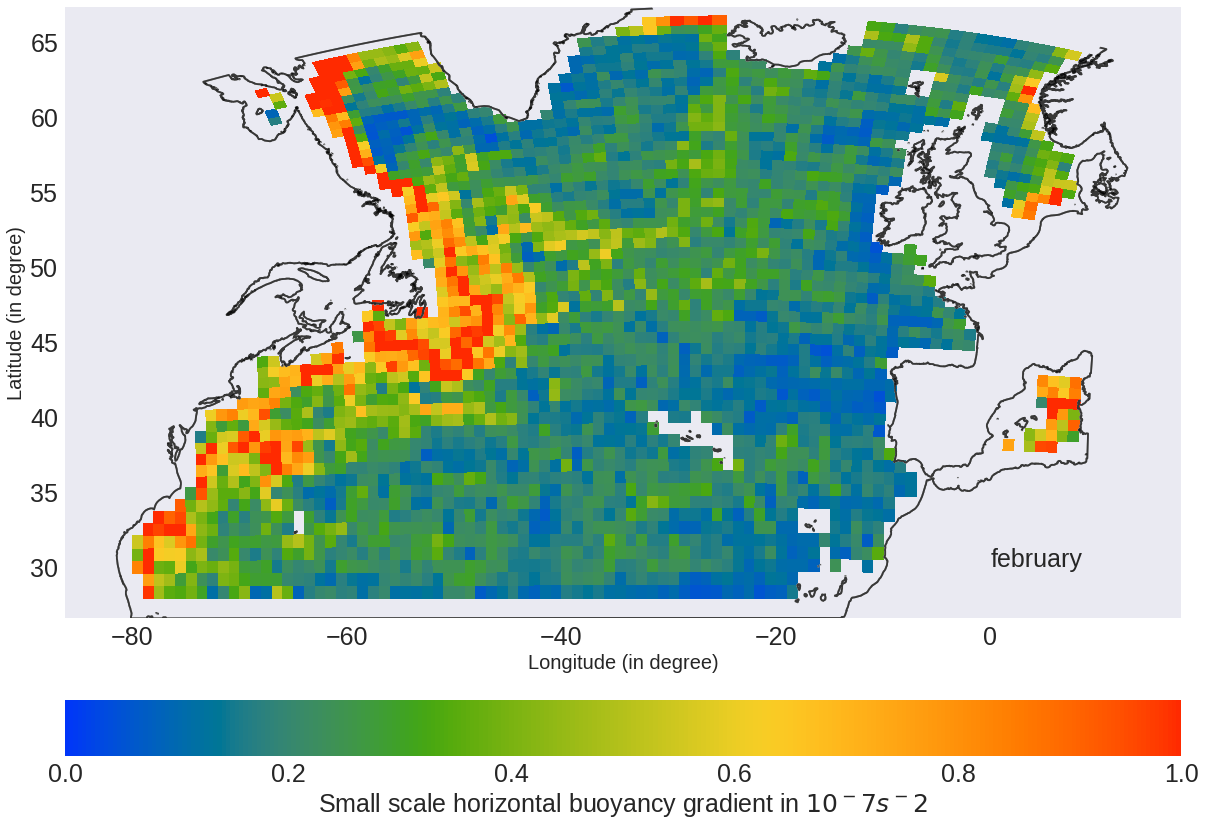

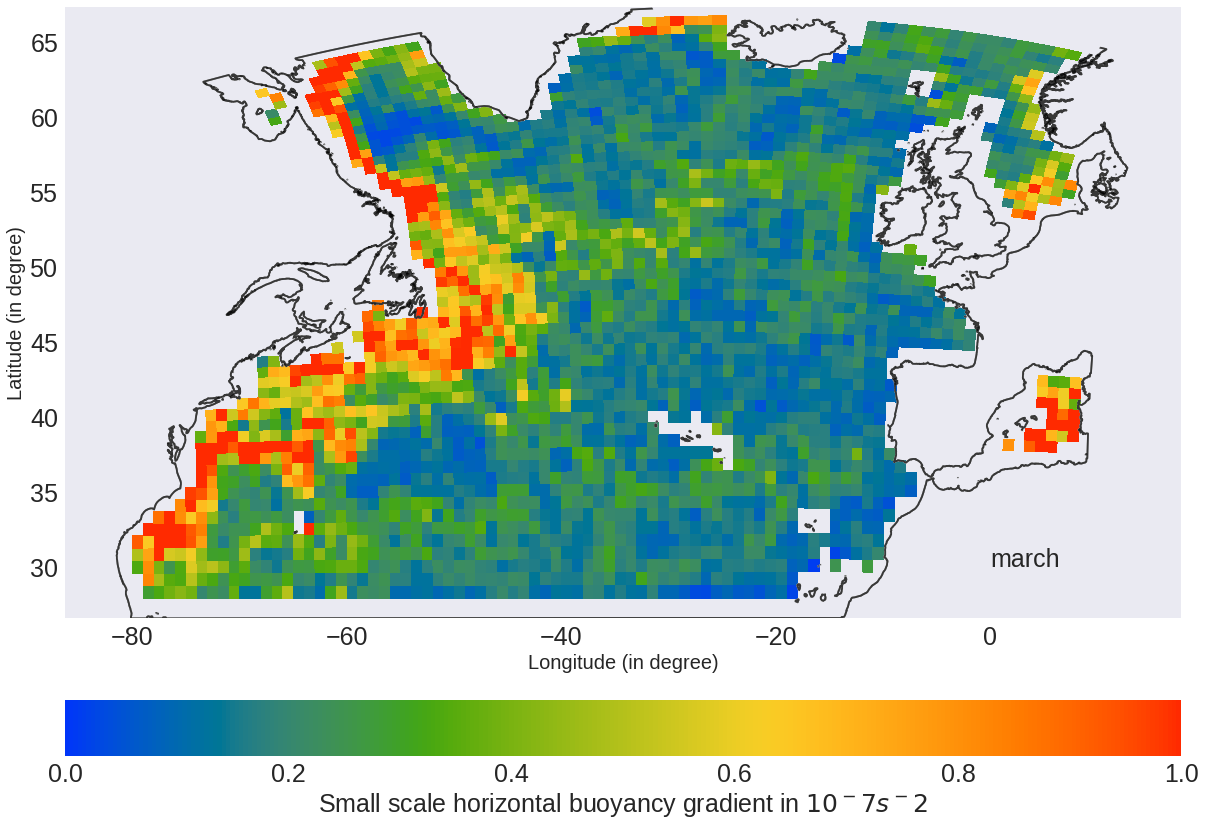

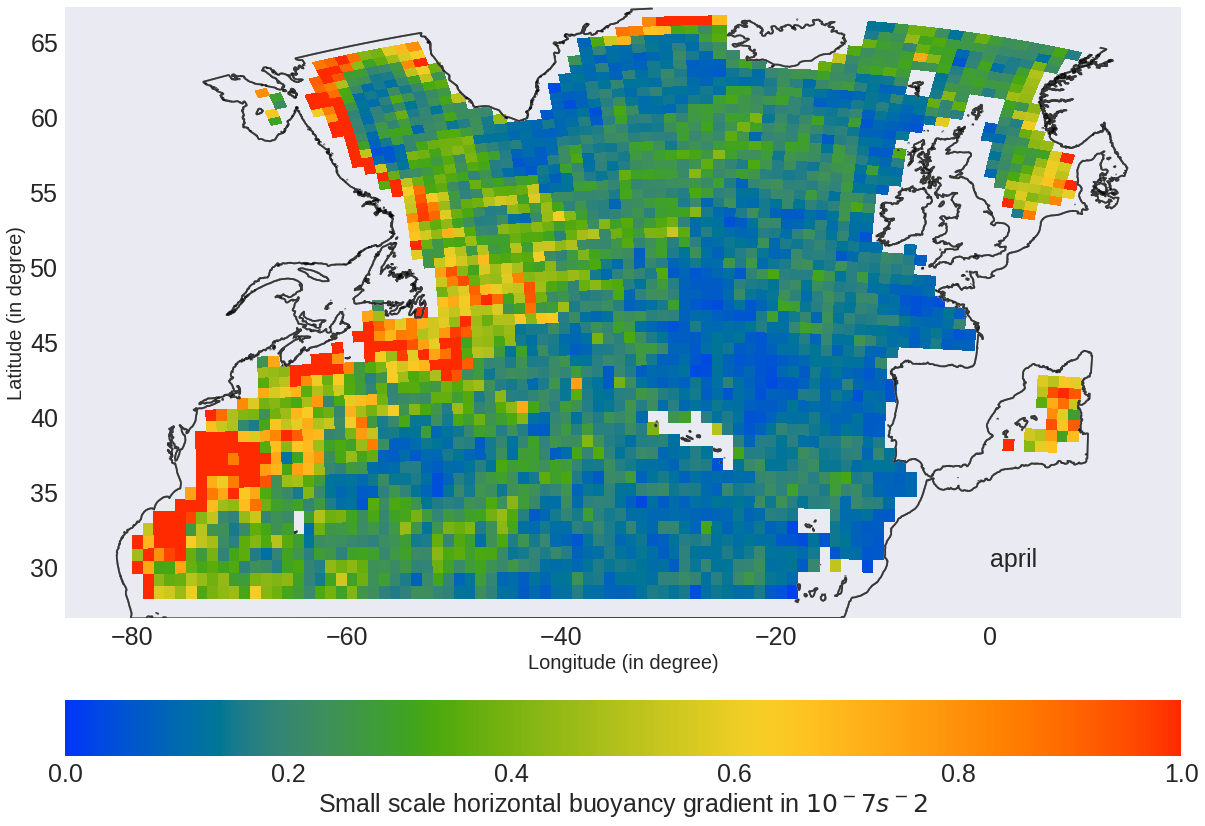

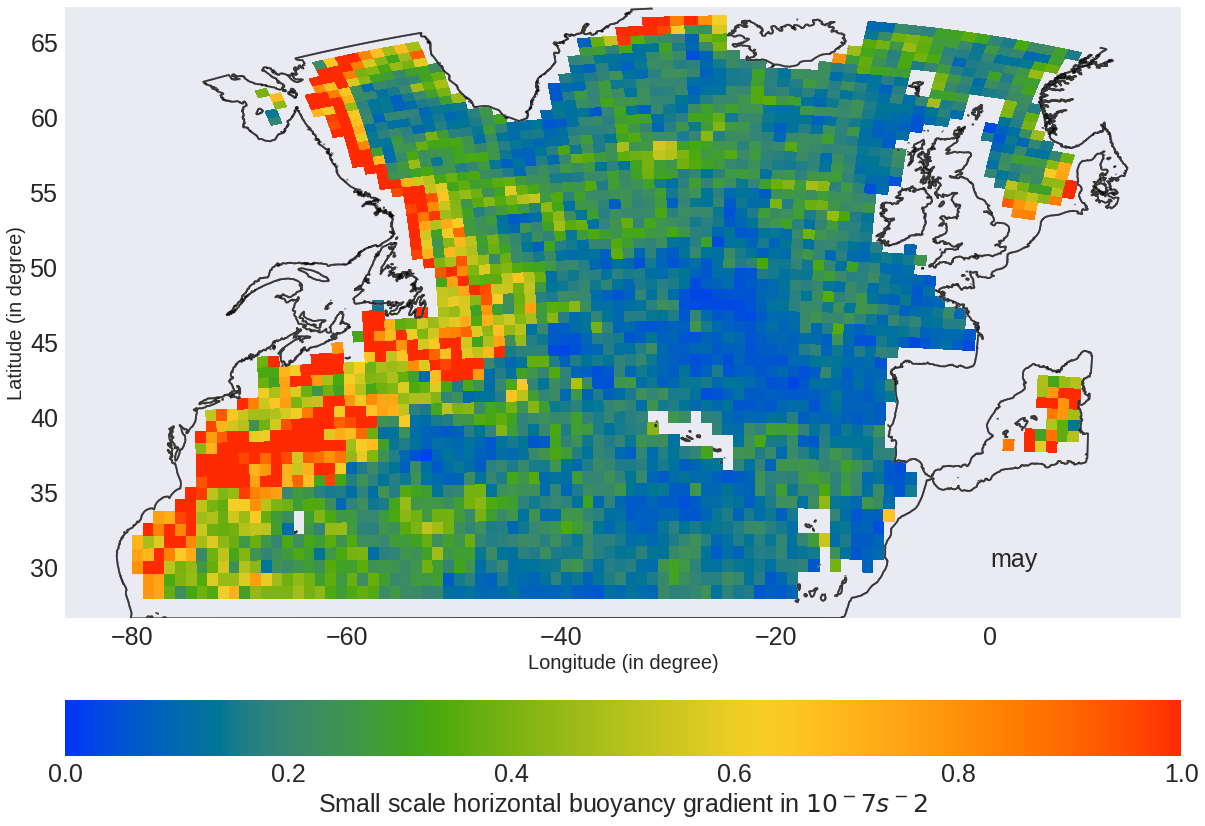

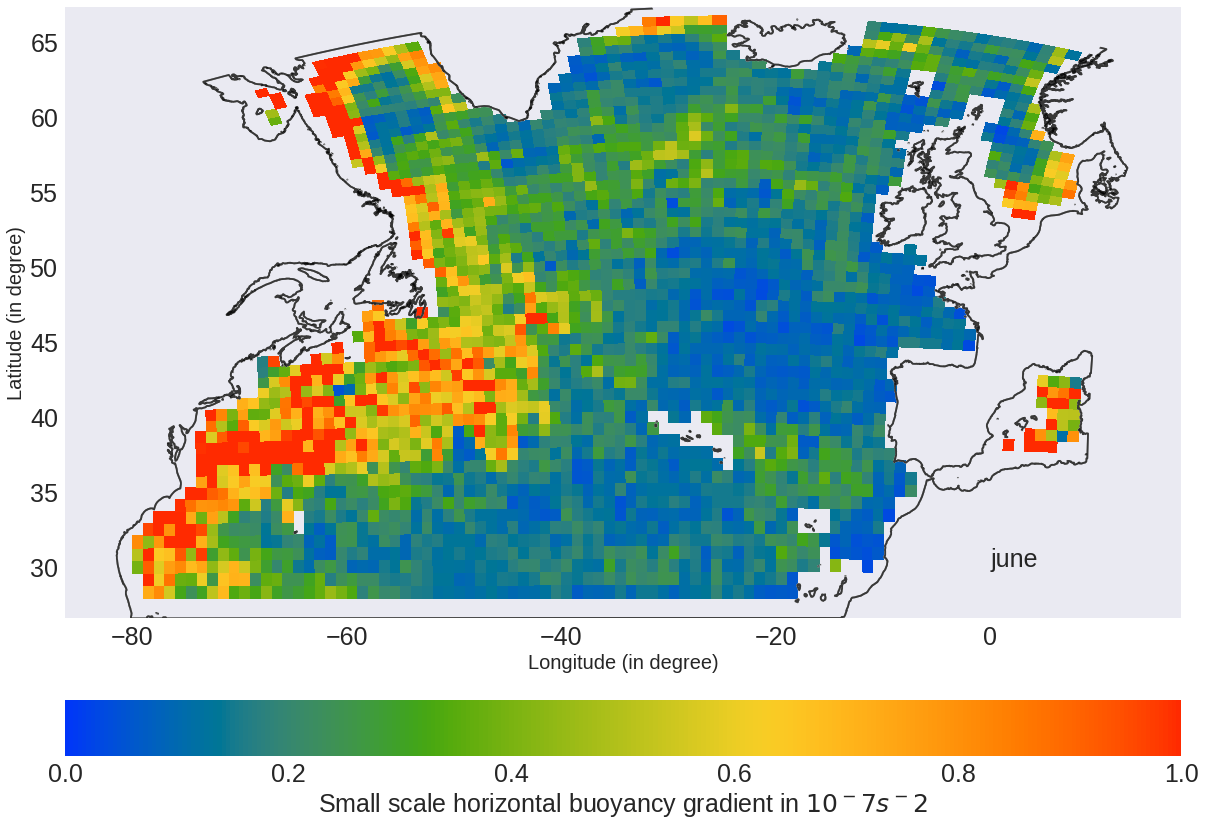

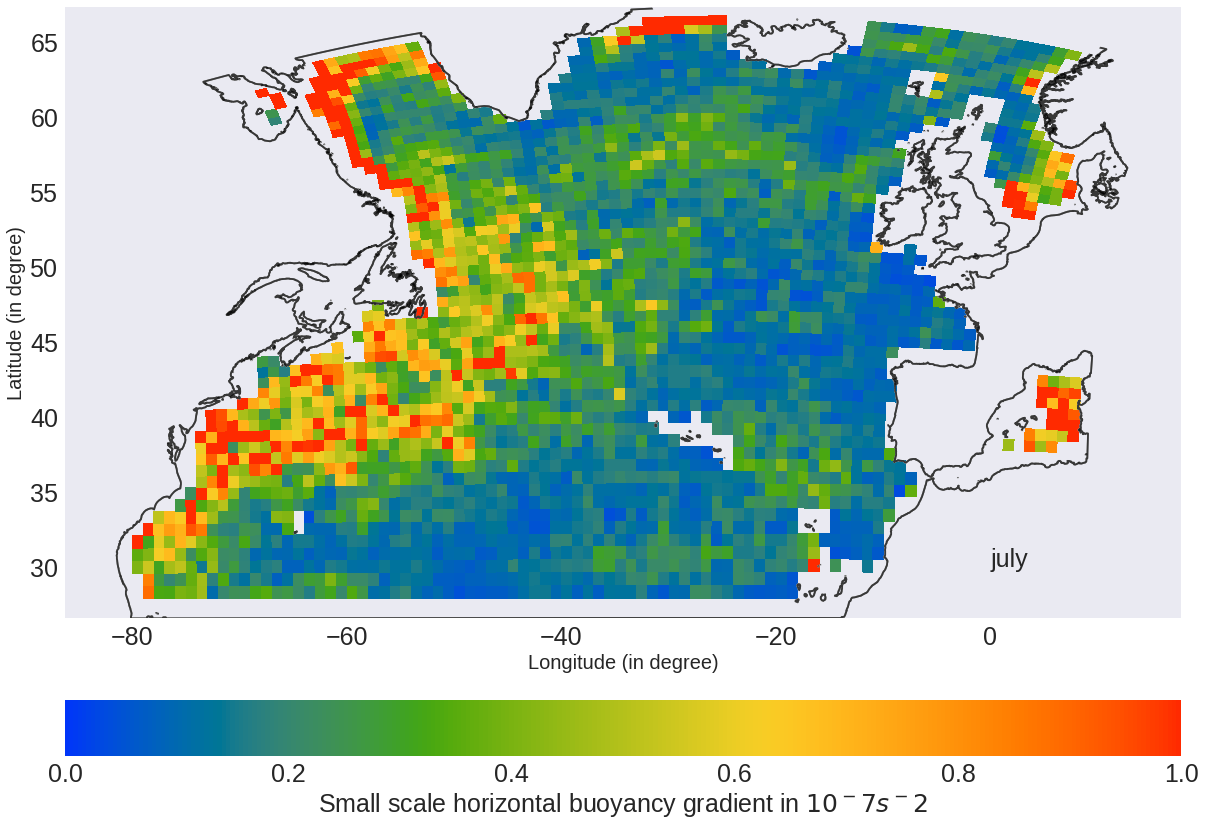

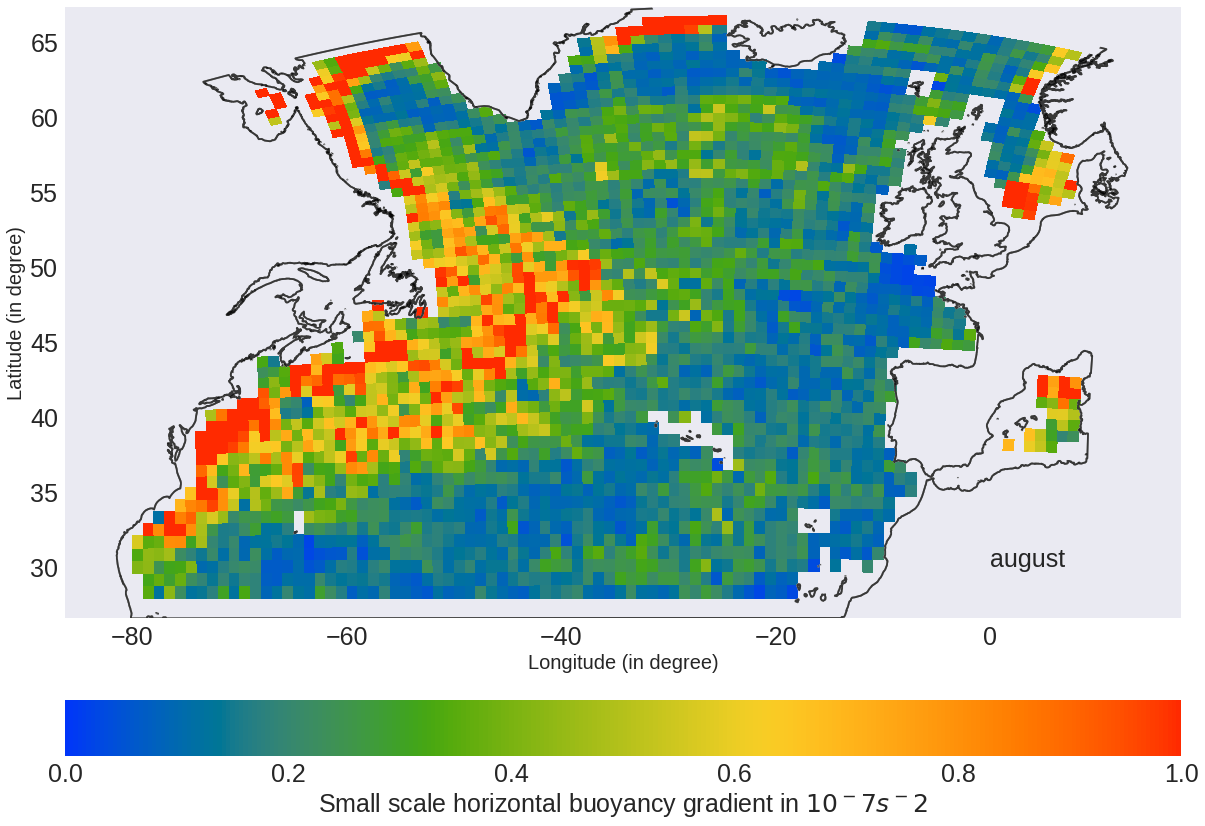

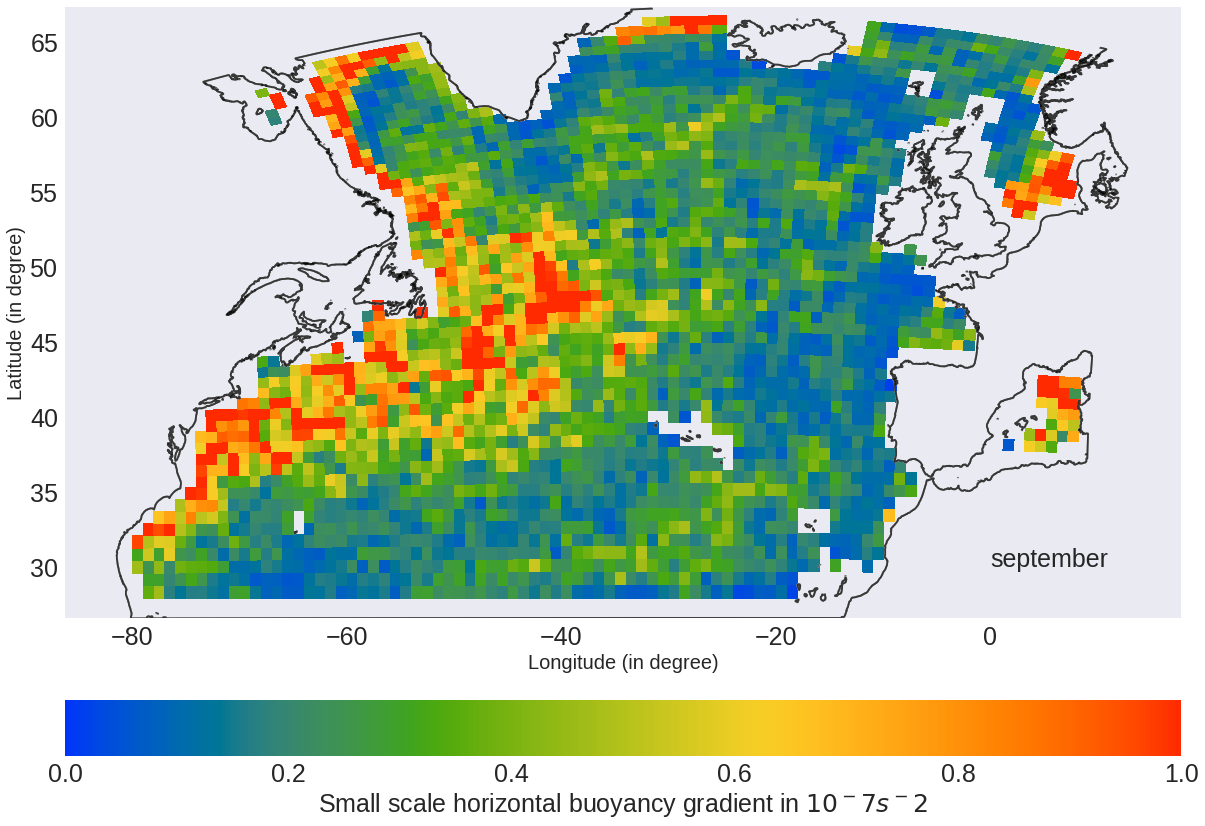

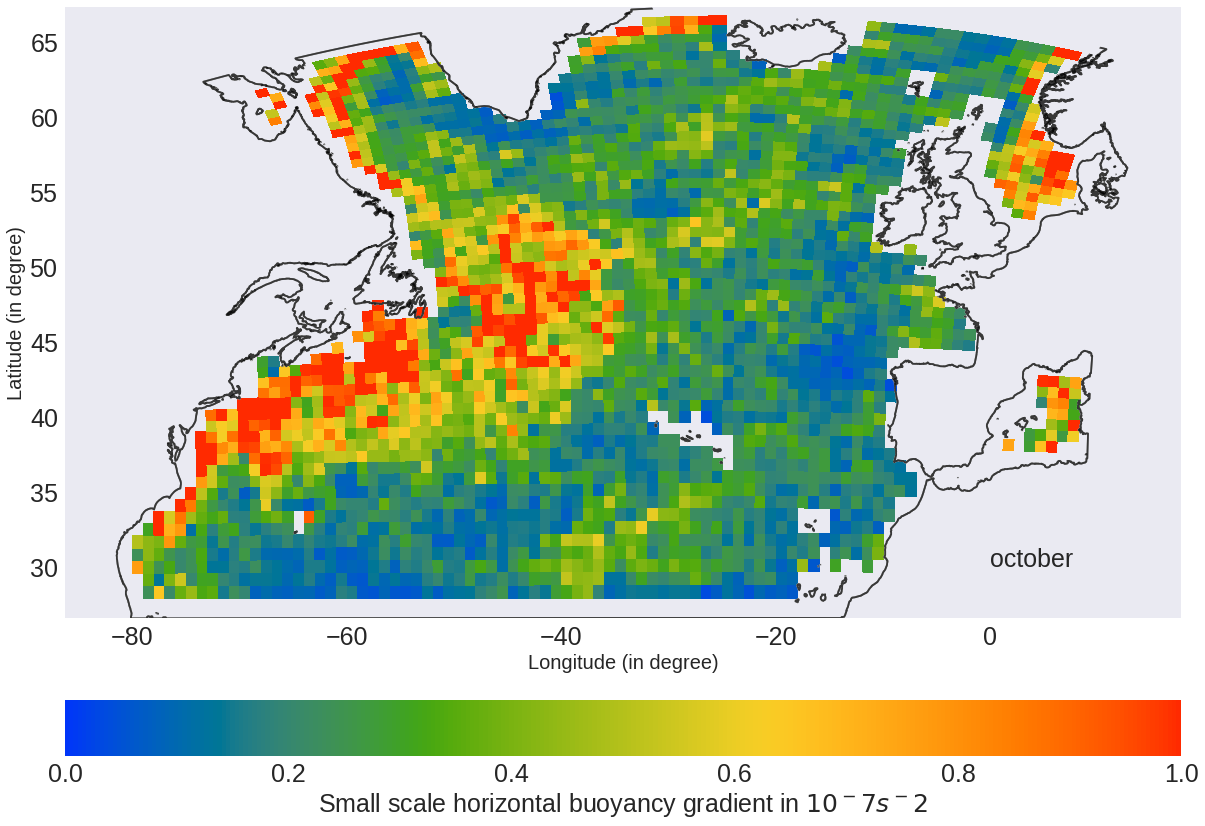

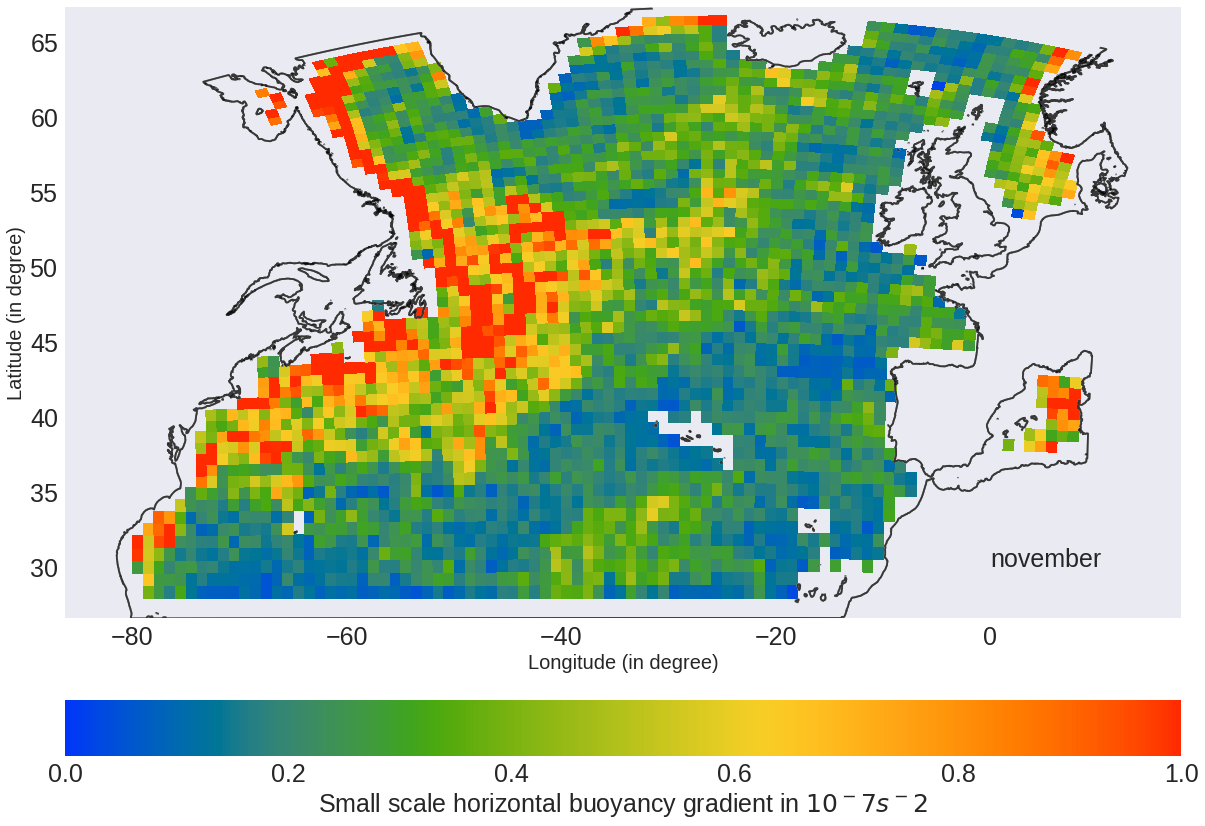

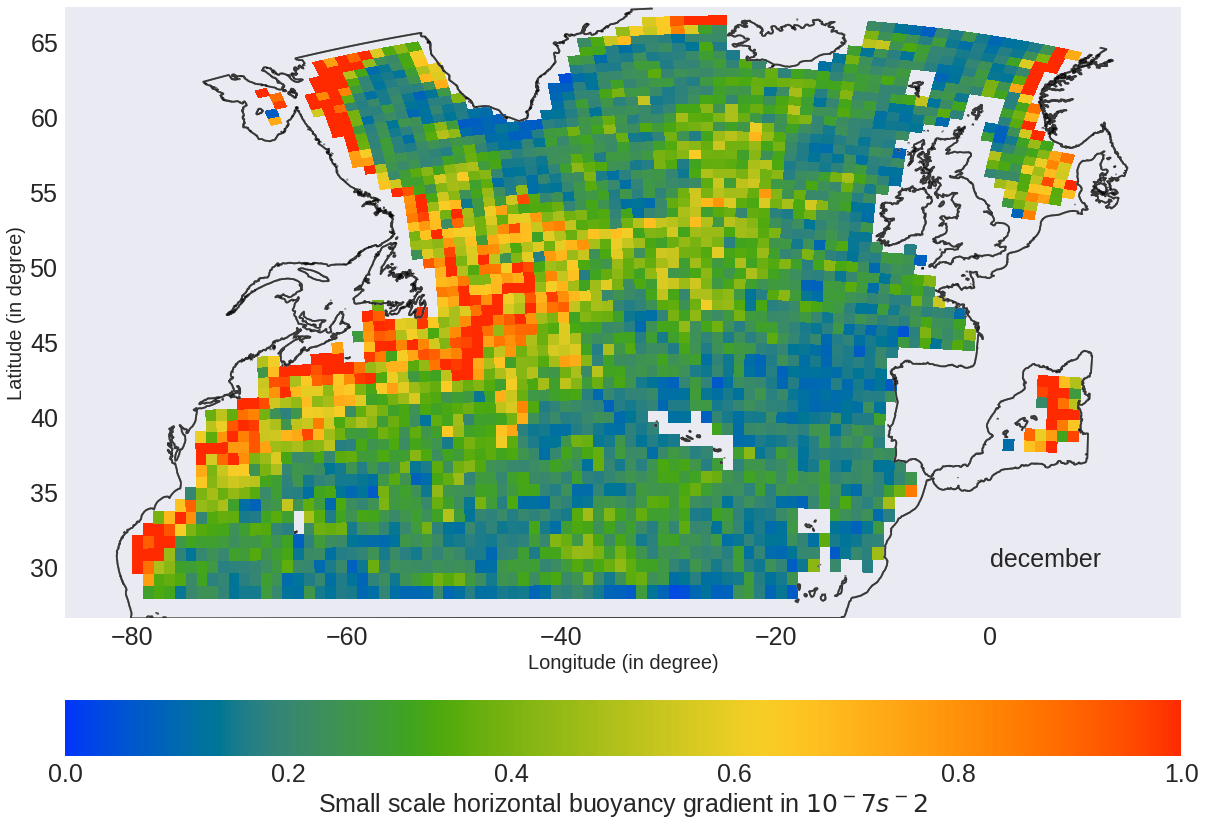

In [16]:
# the maps for the 12 months
for k in np.arange(12):
    plot_hgradb_coarse(k)

In [20]:
# agregating the maps in an animated gif
!convert -delay 120 -loop 0 NATL60_hgrad_small_scale_median_m*.png NATL60_hgrad_small_scale_median.gif

![Animated Monthly Maps of Fine scale Horizontal Buoyancy Gradient](NATL60_hgrad_small_scale_median.gif "Animated Monthly Maps of Fine scale orizontal Buoyancy Gradient")